# SINDy-PI Feature Overview

This notebook provides a simple overview of the basic functionality of SINDy-PI implemented in PySINDy, and is written by Alan Kaptanoglu and Kadierdan Kaheman. SINDy-PI is used to handle generic implicit ODEs (or PDEs) of the form,
$$ \frac{d}{dt}\mathbf{x} = \mathbf{f}(\mathbf{x}, \dot{\mathbf{x}}) \approx \mathbf{\Theta}(\mathbf{x}, \dot{\mathbf{x}})\mathbf{\Xi}$$
This is based off of the paper "Kaheman, K., Kutz, J. N., & Brunton, S. L. (2020). SINDy-PI: a robust algorithm for parallel implicit sparse identification of nonlinear dynamics. Proceedings of the Royal Society A, 476(2242), 20200279." Youtube description can be found here https://www.youtube.com/watch?v=sP8JXF9_wAs.

Building SINDy libraries $\mathbf{\Theta}(\mathbf{x}, \dot{\mathbf{x}})$ depending on both $\mathbf{x}$ and $\dot{\mathbf{x}}$ is possible with the PDE or weakPDE libraries using implicit_terms = True and providing a temporal grid for differentiation. In this case, one must be sure to omit the linear $\dot{\mathbf{x}}$ term in the library (since then the SINDy model will just fit $\dot{\mathbf{x}} = \dot{\mathbf{x}}$) and otherwise be careful about the matrix conditioning, and this is what the SINDyPI optimizer class is for.

The benefit of not using the SINDy-PI functionality is that you can avoid using SymPy (see below).

An interactive version of this notebook is available on binder
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/dynamicslab/pysindy/v1.7.3?filepath=examples/9_sindypi_with_sympy.ipynb)

In [1]:
# Import libraries.
import numpy as np
from matplotlib import pyplot as plt
import pysindy as ps 
from pysindy.differentiation import FiniteDifference
from pysindy.utils import enzyme, bacterial
import sympy as sp
from scipy.integrate import solve_ivp
from sklearn.metrics import r2_score

# For reproducibility
np.random.seed(100)

integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

### Illustration of different ways to make SINDy-PI feature libraries

In [2]:
t = np.linspace(0, 1, 100)
x = np.ones((100, 2))

# Functions to be applied to the data x
functions = [lambda x: np.exp(x), lambda x, y: np.sin(x + y)]

# Functions to be applied to the data x_dot
x_dot_functions = [lambda x: x]

lib = ps.SINDyPILibrary(
    library_functions=functions,
    x_dot_library_functions=x_dot_functions,
    t=t,
).fit(x)
lib.transform(x)
print("Without function names: ")
print(lib.get_feature_names(), "\n")

# Function names includes both the x and x_dot functions
function_names = [
    lambda x: "exp(" + x + ")",
    lambda x, y: "sin(" + x + y + ")",
    lambda x: x,
]
lib = ps.SINDyPILibrary(
    library_functions=functions,
    x_dot_library_functions=x_dot_functions,
    function_names=function_names,
    t=t,
).fit(x)
lib.transform(x)
print("With function names: ")
print(lib.get_feature_names(), "\n")

# SINDyPILibrary is now deprecated, 
# use the PDE or WeakPDE library instead.
function_names = [
    lambda x: "exp(" + x + ")",
    lambda x, y: "sin(" + x + y + ")",
]
lib = ps.PDELibrary(
    function_library=ps.CustomLibrary(library_functions=functions,
    function_names=function_names),
    temporal_grid=t,
    derivative_order=1,
    implicit_terms=True
)
lib = lib.fit(x)
lib.transform(x)
print("With function names: ")
print(lib.get_feature_names(), "\n")

# Repeat with the weak form library
lib = ps.WeakPDELibrary(
    function_library=ps.CustomLibrary(library_functions=functions,
    function_names=function_names),
    spatiotemporal_grid=t,
    K=2, 
    derivative_order=1,
    implicit_terms=True
)
lib = lib.fit(x)
lib.transform(x)
print("With function names: ")
print(lib.get_feature_names(), "\n")


Without function names: 
['f0(x0)', 'f0(x1)', 'f1(x0,x1)', 'f_dot0(x0_dot)', 'f_dot0(x1_dot)', 'f0(x0)f_dot0(x0_dot)', 'f0(x1)f_dot0(x0_dot)', 'f1(x0,x1)f_dot0(x0_dot)', 'f0(x0)f_dot0(x1_dot)', 'f0(x1)f_dot0(x1_dot)', 'f1(x0,x1)f_dot0(x1_dot)'] 

With function names: 
['exp(x0)', 'exp(x1)', 'sin(x0x1)', 'x0_dot', 'x1_dot', 'exp(x0)x0_dot', 'exp(x1)x0_dot', 'sin(x0x1)x0_dot', 'exp(x0)x1_dot', 'exp(x1)x1_dot', 'sin(x0x1)x1_dot'] 

With function names: 
['exp(x0)', 'exp(x1)', 'sin(x0x1)', 'x0_t', 'x1_t', 'exp(x0)x0_t', 'exp(x1)x0_t', 'sin(x0x1)x0_t', 'exp(x0)x1_t', 'exp(x1)x1_t', 'sin(x0x1)x1_t'] 

With function names: 
['exp(x0)', 'exp(x1)', 'sin(x0x1)', 'x0_t', 'x1_t', 'exp(x0)x0_t', 'exp(x1)x0_t', 'sin(x0x1)x0_t', 'exp(x0)x1_t', 'exp(x1)x1_t', 'sin(x0x1)x1_t'] 



### Solve 1D Michelson-Menten enzyme model as first demonstration
The Michelson-Menten enzyme model is,
$$\dot{x} = 0.6 - \frac{1.5 x}{0.3 + x}.$$
Note that, instead of dealing with fractional terms, it can be rearranged into
$$\dot{x} = \frac{3}{5} -3 x - \frac{10}{3} x\dot{x},$$
which is an implicit ODE, since the right-hand-side now depends on $\dot{x}$! In order to handle this scenario, SINDy-PI builds a candidate library with terms depending on both $x$ and $\dot{x}$, and solves the optimization problem, 
$$\|\Theta(x, \dot{x}) - \Theta(x, \dot{x})\Xi\|_2 + \lambda\|\Xi\|_1, \quad s.t. \text{diag}(\Xi) = 0.$$
This reason this modified optimization is required is that linear terms in $\dot{x}$ are no longer guaranteed, so every candidate library term is fit with a different model to find the best combination of implicit terms. Note $\text{diag}(\Xi) = 0$ is required because without this, the model would just fit every candidate library term with itself, $\dot{x} = \dot{x}$, $x\dot{x} = x\dot{x}$, $x^2\dot{x} = x^2\dot{x}$, and so on.

In [3]:
# define parameters
r = 1
dt = 0.001
T = 4
t = np.arange(0, T + dt, dt)
t_span = (t[0], t[-1])
x0_train = [0.55]
x_train = solve_ivp(enzyme, t_span, x0_train, t_eval=t, **integrator_keywords).y.T

# Initialize custom SINDy library so that we can have x_dot inside it. 
library_functions = [
    lambda x: x,
    lambda x, y: x * y,
    lambda x: x ** 2,
    lambda x, y, z: x * y * z,
    lambda x, y: x * y ** 2,
    lambda x: x ** 3,
    lambda x, y, z, w: x * y * z * w,
    lambda x, y, z: x * y * z ** 2,
    lambda x, y: x * y ** 3,
    lambda x: x ** 4,
]
x_dot_library_functions = [lambda x: x]

# library function names includes both 
# the x_library_functions and x_dot_library_functions names
library_function_names = [
    lambda x: x,
    lambda x, y: x + y,
    lambda x: x + x,
    lambda x, y, z: x + y + z,
    lambda x, y: x + y + y,
    lambda x: x + x + x,
    lambda x, y, z, w: x + y + z + w,
    lambda x, y, z: x + y + z + z,
    lambda x, y: x + y + y + y,
    lambda x: x + x + x + x,
    lambda x: x,
]

# Need to pass time base to the library so can build the x_dot library from x
sindy_library = ps.SINDyPILibrary(
    library_functions=library_functions,
    x_dot_library_functions=x_dot_library_functions,
    t=t,
    function_names=library_function_names,
    include_bias=True,
)

sindy_opt = ps.SINDyPI(
    threshold=1e-6,
    tol=1e-8,
    thresholder="l1",
    max_iter=20000,
)

model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
    differentiation_method=ps.FiniteDifference(drop_endpoints=True),
)
model.fit(x_train, t=t)
model.print()

sindy_library.get_feature_names()

Model  0
Model  1
Model  2
Model  3
Solver failed on model  3 , setting coefs to zeros
Model  4
Model  5
Model  6
Model  7
Model  8
Model  9
1 = 5.000 x0 + 1.667 x0_dot + 5.556 x0x0_dot
x0 = 0.200 1 + -0.333 x0_dot + -1.111 x0x0_dot
x0x0 = 0.198 x0 + 0.007 x0x0x0 + -0.338 x0x0_dot + -1.099 x0x0x0_dot
x0x0x0 = 0.000
x0x0x0x0 = -0.001 1 + 0.363 x0x0x0 + 0.041 x0x0_dot + -1.205 x0x0x0x0x0_dot
x0_dot = 0.600 1 + -3.000 x0 + -3.333 x0x0_dot
x0x0_dot = 0.180 1 + -0.900 x0 + -0.300 x0_dot
x0x0x0_dot = -0.004 1 + 0.136 x0 + -0.508 x0x0 + -0.344 x0x0x0 + -0.102 x0x0_dot + -0.219 x0x0x0x0x0_dot
x0x0x0x0_dot = 0.003 1 + 0.001 x0 + -0.391 x0x0x0 + -0.247 x0x0x0x0 + -0.108 x0x0_dot
x0x0x0x0x0_dot = 0.001 1 + -0.670 x0x0x0x0 + -0.005 x0_dot + 0.029 x0x0_dot + -0.271 x0x0x0_dot


['1',
 'x0',
 'x0x0',
 'x0x0x0',
 'x0x0x0x0',
 'x0_dot',
 'x0x0_dot',
 'x0x0x0_dot',
 'x0x0x0x0_dot',
 'x0x0x0x0x0_dot']

In [6]:
library_function_names = [
    lambda x: x,
    lambda x, y: x + y,
    lambda x: x + x,
    lambda x, y, z: x + y + z,
    lambda x, y: x + y + y,
    lambda x: x + x + x,
    lambda x, y, z, w: x + y + z + w,
    lambda x, y, z: x + y + z + z,
    lambda x, y: x + y + y + y,
    lambda x: x + x + x + x,
]

sindy_library = ps.WeakPDELibrary(
#     library_functions=library_functions,
#     function_names=library_function_names,
    function_library=ps.PolynomialLibrary(degree=4,include_bias=False),
    spatiotemporal_grid=t[:,np.newaxis],
    include_bias=True,
    implicit_terms=True,
    derivative_order=1, K=2000,
)

model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
    differentiation_method=ps.FiniteDifference(drop_endpoints=True),
)
model.fit(x_train, t=t)
model.print()
sindy_library.get_feature_names()


Model  0
Model  1
Model  2
Model  3
Model  4
Model  5
Model  6
Model  7
Model  8
Model  9
1 = 5.000 x0 + 1.667 x0_t + 5.555 x0x0_t
x0 = 0.200 1 + 0.010 x0^2 + -0.334 x0_t + -1.097 x0x0_t
x0^2 = 0.019 1 + 0.080 x0 + 0.627 x0^3 + -0.669 x0x0_t
x0^3 = -0.008 1 + 0.373 x0^2 + 0.823 x0^4 + 0.033 x0_t
x0^4 = -0.006 1 + 0.893 x0^3 + -0.021 x0_t + 0.305 x0x0_t
x0_t = 0.597 1 + -2.991 x0 + 0.031 x0^2 + -3.279 x0x0_t
x0x0_t = 0.174 1 + -0.863 x0 + -0.029 x0^2 + -0.285 x0_t
x0^2x0_t = 0.013 1 + -0.247 x0^2 + -0.405 x0^3 + -0.043 x0_t
x0^3x0_t = 0.010 x0 + -0.143 x0^3 + -0.501 x0^4 + -0.006 x0_t
x0^4x0_t = 0.001 1 + -0.479 x0^4 + 0.005 x0_t + -0.060 x0x0_t


['1',
 'x0',
 'x0^2',
 'x0^3',
 'x0^4',
 'x0_t',
 'x0x0_t',
 'x0^2x0_t',
 'x0^3x0_t',
 'x0^4x0_t']

In [7]:
sindy_library = ps.PDELibrary(
#     library_functions=library_functions,
#     function_names=library_function_names,
    function_library=ps.PolynomialLibrary(degree=4,include_bias=False),
    temporal_grid=t,
    include_bias=True,
    implicit_terms=True,
    derivative_order=1
)

model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
    differentiation_method=ps.FiniteDifference(drop_endpoints=True),
)
model.fit(x_train, t=t)
model.print()
sindy_library.get_feature_names()

Model  0
Model  1
Model  2
Model  3
Solver failed on model  3 , setting coefs to zeros
Model  4
Model  5
Model  6
Model  7
Model  8
Model  9
1 = 5.000 x0 + 1.667 x0_t + 5.556 x0x0_t
x0 = 0.200 1 + -0.333 x0_t + -1.111 x0x0_t
x0^2 = 0.198 x0 + 0.007 x0^3 + -0.338 x0x0_t + -1.099 x0^2x0_t
x0^3 = 0.000
x0^4 = -0.001 1 + 0.363 x0^3 + 0.041 x0x0_t + -1.205 x0^4x0_t
x0_t = 0.600 1 + -3.000 x0 + -3.333 x0x0_t
x0x0_t = 0.180 1 + -0.900 x0 + -0.300 x0_t
x0^2x0_t = -0.004 1 + 0.136 x0 + -0.508 x0^2 + -0.344 x0^3 + -0.102 x0x0_t + -0.219 x0^4x0_t
x0^3x0_t = 0.003 1 + 0.001 x0 + -0.391 x0^3 + -0.247 x0^4 + -0.108 x0x0_t
x0^4x0_t = 0.001 1 + -0.670 x0^4 + -0.005 x0_t + 0.029 x0x0_t + -0.271 x0^2x0_t


['1',
 'x0',
 'x0^2',
 'x0^3',
 'x0^4',
 'x0_t',
 'x0x0_t',
 'x0^2x0_t',
 'x0^3x0_t',
 'x0^4x0_t']

### Okay, so how to choose which model to use?
So SINDy-PI has generated a different dynamical model for each of the candidate library terms, but how do we choose which one to use? This can be decided in many ways, but an easy choice is picking the model that minimizes the mean-squared error of the $\dot{x}$ testing data. There are many other ways to choose, and the SINDy-PI paper noted that bad models tend to also be less sparse, so sparsity is another metric for selection. Below, we simply integrate forward all the models and on this testing trajectory, they basically all perform fine. 

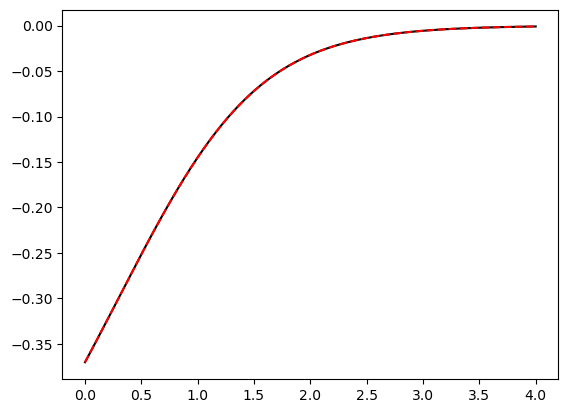

In [8]:
# Plot the fit of the derivative
x_dot_train = model.differentiate(x_train, t)
x_dot_train_pred = model.predict(x_train)[:, 5]  # will default to d/dt of all the features
plt.figure()
plt.plot(t, x_dot_train, 'k')
plt.plot(t, x_dot_train_pred, 'r--')

### Now we need to reformat all the feature strings for conversion into symbolic variables
So we have all these nice models but these are implicit ODEs, and the default Python solvers (solve_ivp and odeint) cannot solve implicit ODEs. There are two options although we only illustrate the first option below; we must convert the equations into symbolic variables and then either (1) use SymPy to symbolically solve the equation for $\dot{x}$, after which the equation is no longer implicit and can be solved with the default Python solves, or (2) convert the equations into a symbolic differential algebraic equation (DAE), which can be numerically solved with the diffeqpy Python package (but requires Julia to be installed). 

In [9]:
features = model.get_feature_names()
features[0] = "1"
features_copy = list(np.copy(features))
nfeatures = len(features)
features_formatted = []
# Need to put multiplication between terms for sympy
for i in range(nfeatures):
    for j in range(r):
        # Overkill to make sure all the x0, x1, etc. get replaced
        temp_string = features[i].replace("x" + str(j) + "x", "x" + str(j) + " * x")
        temp_string = temp_string.replace("x" + str(j) + "x", "x" + str(j) + " * x")
        temp_string = temp_string.replace("x" + str(j) + "x", "x" + str(j) + " * x")
        temp_string = temp_string.replace("x" + str(j) + "x", "x" + str(j) + " * x")
        features[i] = temp_string
    features_formatted.append(temp_string)
features = features_copy
print(features)
print(features_formatted)
coefs = model.coefficients()
sym_features = [sp.symbols(feature) for feature in features]
sym_theta = [sp.symbols(feature) for feature in features]

['1', 'x0', 'x0^2', 'x0^3', 'x0^4', 'x0_t', 'x0x0_t', 'x0^2x0_t', 'x0^3x0_t', 'x0^4x0_t']
['1', 'x0', 'x0^2', 'x0^3', 'x0^4', 'x0_t', 'x0 * x0_t', 'x0^2x0_t', 'x0^3x0_t', 'x0^4x0_t']


### Check all the model fits produce sensible models

In [10]:
sym_equations = []
sym_equations_rounded = []
for i in range(nfeatures):
    sym_equations.append(
        sp.solve(
            sp.Eq(sym_theta[i], sym_theta @ np.around(coefs[i], 10)), sym_features[i]
        )
    )
    sym_equations_rounded.append(
        sp.solve(
            sp.Eq(sym_theta[i], sym_theta @ np.around(coefs[i], 2)), sym_features[i]
        )
    )
    print(sym_theta[i], " = ", sym_equations_rounded[i][0])

1  =  5.0*x0 + 1.67*x0_t + 5.56*x0x0_t
x0  =  0.2*1 - 0.33*x0_t - 1.11*x0x0_t
x0^2  =  0.2*x0 - 1.1*x0^2x0_t + 0.01*x0^3 - 0.34*x0x0_t
x0^3  =  0
x0^4  =  0.36*x0^3 - 1.21*x0^4x0_t + 0.04*x0x0_t
x0_t  =  0.6*1 - 3.0*x0 - 3.33*x0x0_t
x0x0_t  =  0.18*1 - 0.9*x0 - 0.3*x0_t
x0^2x0_t  =  0.14*x0 - 0.51*x0^2 - 0.34*x0^3 - 0.22*x0^4x0_t - 0.1*x0x0_t
x0^3x0_t  =  -0.39*x0^3 - 0.25*x0^4 - 0.11*x0x0_t
x0^4x0_t  =  -0.27*x0^2x0_t - 0.67*x0^4 - 0.01*x0_t + 0.03*x0x0_t


### Now we will:
1. reformat all the equations
2. solve symbolically for x_dot 
3. integrate and plot the new equations for x_dot

In [11]:
# Define the ODE symbol variables
t_sym = sp.symbols("t_sym")
x_sym = sp.symbols("x:%d" % r)
x_dot_sym = sp.symbols("x:%d_t" % r)

# Need to format the above equations so that there are space between x0 * x0, x0 * x_dot0, and so on.
sym_equations_formatted = []
sym_equations_rounded_formatted = []
for i in range(nfeatures):
    for j in range(r):
        # Overkill to make sure all the x0, x1, etc. get replaced
        temp_string = str(sym_equations[i]).replace(
            "x" + str(j) + "x", "x" + str(j) + " * x"
        )
        temp_string = temp_string.replace("x" + str(j) + "x", "x" + str(j) + " * x")
        temp_string = temp_string.replace("x" + str(j) + "x", "x" + str(j) + " * x")
        temp_string = temp_string.replace("x" + str(j) + "x", "x" + str(j) + " * x")
        temp_rounded_string = str(sym_equations_rounded[i]).replace(
            "x" + str(j) + "x", "x" + str(j) + " * x"
        )
        temp_rounded_string = temp_rounded_string.replace(
            "x" + str(j) + "x", "x" + str(j) + " * x"
        )
        temp_rounded_string = temp_rounded_string.replace(
            "x" + str(j) + "x", "x" + str(j) + " * x"
        )
        temp_rounded_string = temp_rounded_string.replace(
            "x" + str(j) + "x", "x" + str(j) + " * x"
        )
        sym_equations_formatted.append(temp_string)
        sym_equations_rounded_formatted.append(temp_rounded_string)

# Now that the equations are mathematically formatted, 
# solve for x_dot0 in the algebraic equation.
sym_equations_simplified = []
sym_equations_rounded_simplified = []
for i in range(nfeatures):
    sym_equations_simplified.append(
        sp.solve(
            sp.Add(
                sp.sympify(sym_equations_formatted)[i][0],
                -sp.sympify(features_formatted[i]),
            ),
            x_dot_sym,
        )
    )
    rounded = sp.solve(
        sp.Add(
            sp.sympify(sym_equations_rounded_formatted)[i][0],
            -sp.sympify(features_formatted[i]),
        ),
        x_dot_sym,
    )
    if len(rounded) != 0:
        rounded_temp = rounded[0]
        for a in sp.preorder_traversal(rounded):
            if isinstance(a, sp.Float):
                rounded_temp = rounded_temp.subs(a, round(a, 2))
        sym_equations_rounded_simplified.append(rounded_temp)
    else:
        sym_equations_rounded_simplified.append([])

# Plot the results for each of the models
plt.figure(figsize=(16, 3))
x0_test = np.random.rand(1)
x_test = solve_ivp(enzyme, t_span, x0_test, t_eval=t).y.T
plt.plot(t, x_test, color="k", linestyle="solid", label="True")
for i in range(nfeatures):
    ax = plt.gca()
    if i != nfeatures - 1:
        ax.set_xticklabels([])
    if len(sym_equations_simplified[i]) != 0:
        ODE_Func = sp.lambdify([t_sym, x_sym], sym_equations_simplified[i][0])

        # Now simulate the system we identified
        x_test_sim = solve_ivp(ODE_Func, t_span, x0_test, t_eval=t).y.T
        if (
            np.linalg.norm(x_test_sim) < 1e3
            and sym_equations_rounded_simplified[i] != 0
        ):
            plt.plot(
                t,
                x_test_sim,
                linestyle="dashed",
                label=str(sp.sympify(features_formatted[i]))
                + " = "
                + str(sym_equations_rounded_simplified[i]),
            )
plt.grid(True)
plt.legend(fontsize=8)

SympifyError: Sympify of expression 'could not parse '[4.9999999995*x0 - 7.219999999278e-8*x0^2 + 6.359999999364e-8*x0^2x0_t - 1.2109999998789e-7*x0^3 + 7.69999999923e-8*x0^3x0_t - 1.2049999998795e-7*x0^4 + 6.339999999366e-8*x0^4x0_t + 1.66666574513333*x0_t + 5.55555742084444*x0 * x0_t]'' failed, because of exception being raised:
SyntaxError: invalid syntax. Perhaps you forgot a comma? (<string>, line 1)

### Solve high-order ODE
In general, high order ODEs can always be transformed into an equivalent (but higher-dimensional) set of 1st-order ODEs. However, this means that the user would have to provide the data for $\mathbf x$, $\dot{\mathbf x}$, $\ddot{\mathbf x}$, ... and then the weak formulation cannot be easily used for computing these derivative terms. Here we show how a high-order ODE (which is long-time unstable in general)
$$x_{tt} = (1-x_{t}^2)x_t - x$$
can be identified directly with the PDE or WeakPDE libraries, without rewriting the equation as a system of 1st order ODEs and directly providing data for all $\mathbf x$, ..., $\mathbf x_{ttt}$.

With function names: 
['1', 'x0', 'x0^2', 'x0^3', 'x0^4', 'x0_t', 'x0_tt', 'x0x0_t', 'x0^2x0_t', 'x0^3x0_t', 'x0^4x0_t', 'x0x0_tt', 'x0^2x0_tt', 'x0^3x0_tt', 'x0^4x0_tt'] 

Model  0
Model  1
Model  2
Model  3
Model  4
Model  5
Model  6
Model  7
Model  8
Model  9
Model  10
Model  11
Model  12
Model  13
Model  14
1 = -0.1820 x0 + 1.3321 x0^2 + 0.0079 x0^3 + -0.2365 x0^4 + -0.3367 x0_t + -1.5309 x0_tt + 0.3257 x0x0_t + 0.1693 x0^2x0_t + -0.1519 x0^3x0_t + -0.0072 x0^4x0_t + 1.3000 x0x0_tt + 0.6402 x0^2x0_tt + -0.2802 x0^3x0_tt + -0.0741 x0^4x0_tt
x0 = -0.0701 1 + 0.1293 x0^2 + 0.5855 x0^3 + -0.0060 x0^4 + -0.3834 x0_t + -1.4936 x0_tt + 0.1162 x0x0_t + 0.7539 x0^2x0_t + -0.0618 x0^3x0_t + -0.2831 x0^4x0_t + 0.3308 x0x0_tt + 1.3294 x0^2x0_tt + -0.0564 x0^3x0_tt + -0.1438 x0^4x0_tt
x0^2 = 0.3891 1 + 0.0981 x0 + 0.0273 x0^3 + 0.1963 x0^4 + 0.2397 x0_t + 1.1933 x0_tt + -0.3316 x0x0_t + -0.0813 x0^2x0_t + 0.1536 x0^3x0_t + -0.0138 x0^4x0_t + -1.4488 x0x0_tt + -0.4520 x0^2x0_tt + 0.3192 x0^3x0_t

['1',
 'x0',
 'x0^2',
 'x0^3',
 'x0^4',
 'x0_t',
 'x0_tt',
 'x0x0_t',
 'x0^2x0_t',
 'x0^3x0_t',
 'x0^4x0_t',
 'x0x0_tt',
 'x0^2x0_tt',
 'x0^3x0_tt',
 'x0^4x0_tt']

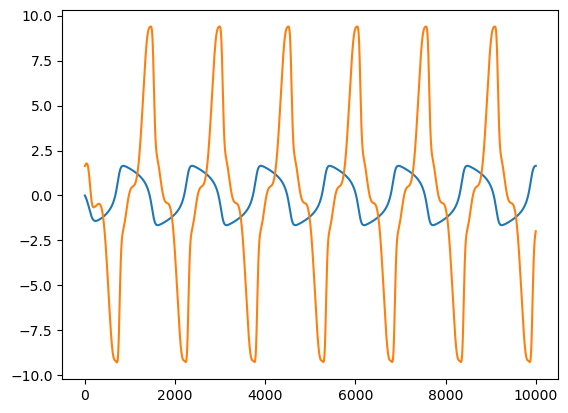

In [12]:
def Rayleigh_osc(t, x):
    return [x[1], (2 - (x[1]) ** 2) * x[1] - x[0]]

# Generate measurement data
dt = 0.005
t_train = np.arange(0, 50, dt)
t_train_span = (t_train[0], t_train[-1])

x0_train = [1, 0]
x_train = solve_ivp(Rayleigh_osc, t_train_span, x0_train,
                    t_eval=t_train, **integrator_keywords).y.T

# Only train on the data for x, chop the other variable!
x_train = x_train[:, 0].reshape(len(t_train), 1)

# Define custom functions up to quadratic terms
library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]

# Define PDELibrary which generates up to first order temporal derivatives
sindy_library = ps.PDELibrary(
#     library_functions=library_functions,
#     function_names=library_function_names,
    function_library=ps.PolynomialLibrary(degree=4,include_bias=False),
    temporal_grid=t_train,
    include_bias=True,
    implicit_terms=True,
    derivative_order=2
)

lib = sindy_library.fit(x_train)
lib.transform(x_train)
print("With function names: ")
print(lib.get_feature_names(), "\n")

sindy_opt = ps.SINDyPI(
    threshold=1e-4,
    tol=1e-5,
    thresholder="l1",
    max_iter=6000,
    #normalize_columns=True
)

model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
)
model.fit(x_train, t=t_train)
model.print(precision=4)

x_dot_true = model.differentiate(x_train, t=t_train)
x_dot_pred = model.predict(x_train)  # default returns d/dt of all 15 features!

plt.figure()
plt.plot(x_dot_true)
plt.plot(x_dot_pred[:, 3])
         
sindy_library.get_feature_names()

### Find complex PDE with SINDy-PI with PDE functionality
So far, we have focused on implicit, complex ODEs that require SINDy-PI for identification. There are also complex PDEs that can only be adequately identified with SINDy-PI, and here we show how to do so. We will consider the modified KdV equation used in the Youtube lecture (see link at the beginning of this notebook):
$$u_t = -u_{xxx} + 6uu_x - 0.1 u + \frac{2}{1+u}.$$
Thanks to the (1+u) term in the denominator, it will be difficult to identify this PDE unless the functional dependence is already known. But we can instead use the typical polynomial + derivatives library if using SINDy-PI, where we multiply both sides by (1+u) and instead solve for the equation:
$$u_t = -u_{xxx}(1+u) + 6u(1+u)u_x - 0.1 u(1+u) + 2 - uu_t.$$
We can generate the required terms using a PDELibrary class with both spatial and temporal derivatives up to third order, and up to quadratic polynomial terms. 

In [13]:
np.random.seed(100)

integrator_keywords = {}
integrator_keywords['rtol'] = 1e-8
integrator_keywords['method'] = 'Radau'
integrator_keywords['atol'] = 1e-8

dt=0.1
t=dt*np.arange(201)
nx=768
L=90
g=0.01

def mkdv(t, u, L, nx):
    ux=ps.FiniteDifference(d=1,axis=0,order=4,periodic=True)._differentiate(u,L/nx)
    uxxx=ps.FiniteDifference(d=3,axis=0,order=4,periodic=True)._differentiate(u,L/nx)
    return -1.0*uxxx-6.0*u*ux -0.1*u+2*g/(1+u)

c1=1
c2=0.5
t0=42
x0=24
X= -L/2+np.arange(nx)*L/nx
x1=X+c1*t0-x0
x2=X+c2*t0-x0
u0=2*(c1-c2)*(c1*np.cosh(c2**0.5/2*x2)**2+c2*np.cosh(c1**0.5/2*x1)**2)/((c1**0.5-c2**0.5)*np.cosh((c1**0.5*x1+c2**0.5*x2)/2)+(c1**0.5+c2**0.5)*np.cosh((c1**0.5*x1-c2**0.5*x2)/2))**2
sol_mkdv = solve_ivp(mkdv, (t[0], t[-1]), y0=u0, t_eval=t, args=(L, nx),**integrator_keywords)

x=X[128:-128]
u=sol_mkdv.y[128:-128,:,np.newaxis]
t=sol_mkdv.t

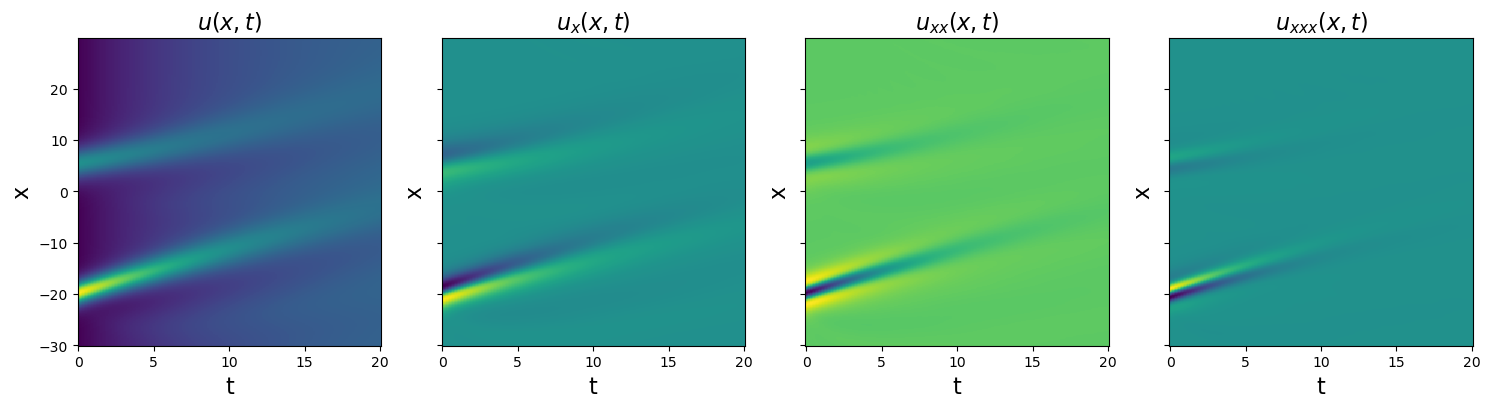

In [14]:
dx=x[1]-x[0]
dt=t[1]-t[0]
ux = ps.FiniteDifference(d=1, axis=0)._differentiate(u, dx)
uxx = ps.FiniteDifference(d=2, axis=0)._differentiate(u, dx)
uxxx = ps.FiniteDifference(d=3, axis=0)._differentiate(u, dx)

# Plot derivative results
plt.figure(figsize=(18, 4))
plt.subplot(1, 4, 1)
plt.pcolormesh(t, x, u[:,:,0])
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
plt.title(r'$u(x, t)$', fontsize=16)
plt.subplot(1, 4, 2)
plt.pcolormesh(t, x, ux[:,:,0])
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r'$u_{x}(x, t)$', fontsize=16)
plt.subplot(1, 4, 3)
plt.pcolormesh(t, x, uxx[:,:,0])
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r'$u_{xx}(x, t)$', fontsize=16)
plt.subplot(1, 4, 4)
plt.pcolormesh(t, x, uxxx[:,:,0])
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r'$u_{xxx}(x, t)$', fontsize=16)
plt.show()

In [16]:
# Define PDE library that is quadratic in u, and 
# third-order in spatial derivatives of u.
spatiotemporal_grid=np.zeros((len(x),201,2))
spatiotemporal_grid[:,:,0]=x[:,np.newaxis]
spatiotemporal_grid[:,:,1]=t[np.newaxis,:]

library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
np.random.seed(1)

pde_lib = ps.PDELibrary(function_library=ps.PolynomialLibrary(degree=2,include_bias=False),
#                         library_functions=library_functions, 
#                         function_names=library_function_names, 
                        derivative_order=3, spatial_grid=x, 
                        include_bias=False, is_uniform=True)

# Fit the model with different optimizers.
print('SR3 model: ')
optimizer = ps.SR3(threshold=1, max_iter=10000, tol=1e-15, nu=1e2,
                   thresholder='l1', normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, t=dt)
model.print()
print('score', model.score(u,t=dt))

SR3 model: 
(x0)' = 0.134 x0 + -0.749 x0^2 + -0.069 x0_1 + 0.107 x0_11 + -0.575 x0_111 + -3.603 x0x0_1 + -0.203 x0^2x0_1 + -1.424 x0x0_11
score 0.8354105241782908


In [17]:
multiindices=np.array([[0,1],[1,0],[2,0],[3,0]])
pde_lib = ps.PDELibrary(function_library=ps.PolynomialLibrary(degree=2,include_bias=False),
#                         library_functions=library_functions, 
#                         function_names=library_function_names, 
                        derivative_order=3, spatial_grid=x, temporal_grid=t, 
                        include_bias=False, is_uniform=True,implicit_terms=True, multiindices=multiindices)

sindy_opt = ps.SINDyPI(
    threshold=1e-1, max_iter=1000, tol=1e-10,
    thresholder='l1', normalize_columns=False
)
model = ps.SINDy(feature_library=pde_lib, optimizer=sindy_opt)
model.fit(u, t=dt)
model.print()

Model  0
Model  1
Model  2
Model  3
Model  4
Model  5
Model  6
Model  7
Model  8
Model  9
Model  10
Model  11
Model  12
Solver failed on model  12 , setting coefs to zeros
Model  13
x0 = 5.800 x0^2 + 0.843 x0_t + -4.165 x0_1 + -0.157 x0_11 + 5.866 x0_111 + 36.264 x0x0_t + 63.961 x0x0_1 + 8.435 x0^2x0_1 + 2.056 x0x0_11
x0^2 = 0.170 x0 + -0.348 x0_t + 0.038 x0_1 + 0.031 x0_11 + -0.385 x0_111 + -2.340 x0x0_t + -4.298 x0x0_1 + -1.032 x0x0_11 + 0.105 x0x0_111
x0_t = 0.109 x0 + -0.582 x0^2 + -0.544 x0_1 + 0.227 x0_11 + -0.365 x0_111 + 2.512 x0x0_t + -1.449 x0x0_11
x0_1 = -0.023 x0 + 0.149 x0^2 + -0.143 x0_t + 0.063 x0_11 + 0.670 x0_111 + 1.995 x0x0_t + 7.580 x0x0_1 + -0.130 x0x0_11 + 0.759 x0x0_111
x0_11 = -0.009 x0 + 0.076 x0^2 + 0.147 x0_t + 0.144 x0_1 + 0.032 x0_111 + 5.806 x0x0_11 + -7.664 x0^2x0_11 + -0.036 x0x0_111
x0_111 = 0.031 x0 + -0.172 x0^2 + -0.181 x0_t + 0.315 x0_1 + -0.162 x0x0_t + -3.851 x0x0_1 + -0.181 x0x0_11 + 0.885 x0x0_111
x0x0_t = 0.007 x0 + -0.044 x0^2 + 0.071 x0_t + -

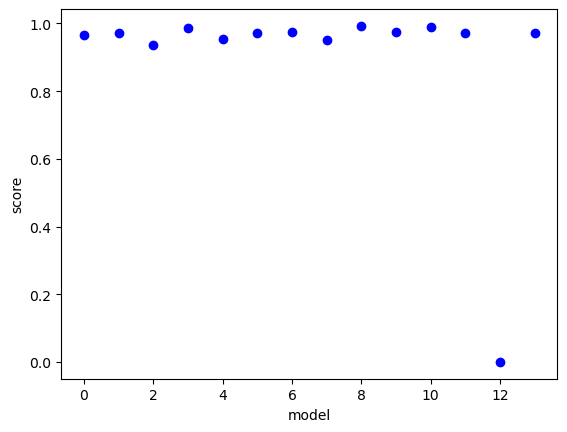

x0x0_1=0.002 x0 + -0.011 x0^2 + -0.023 x0_t + 0.112 x0_1 + -0.158 x0_111 + -0.065 x0x0_t, score=0.9927185976382495
x0x0_11=0.006 x0 + -0.043 x0^2 + -0.007 x0_t + -0.007 x0_1 + 0.140 x0_11 + 1.274 x0^2x0_11, score=0.9904594725824567
x0_1=-0.023 x0 + 0.149 x0^2 + -0.143 x0_t + 0.063 x0_11 + 0.670 x0_111 + 1.995 x0x0_t + 7.580 x0x0_1 + -0.130 x0x0_11 + 0.759 x0x0_111, score=0.9862037161025926
x0x0_t=0.007 x0 + -0.044 x0^2 + 0.071 x0_t + -0.040 x0_1 + 0.022 x0_11 + 0.090 x0_111 + -0.120 x0x0_1 + 0.039 x0x0_11 + 0.121 x0x0_111, score=0.9759556862567613
x0^2x0_1=-0.010 x0_t + 0.010 x0_1 + -0.059 x0_111 + -0.065 x0x0_111, score=0.9743061078646322


In [20]:
lhs_actual=pde_lib.transform(u)
lhs_predict=model.predict(u)


scores=[r2_score(np.reshape(lhs_actual[:,:,ind],(np.prod(lhs_actual.shape[:-1]))),np.reshape(lhs_predict[:,:,ind],(np.prod(lhs_actual.shape[:-1])))) for ind in range(lhs_predict.shape[-1])]

plt.plot(scores,'bo')
plt.xlabel('model')
plt.ylabel('score')
plt.show()

order=np.argsort(scores)
for ind in np.flip(order[-5:]):
    print(pde_lib.get_feature_names()[ind] + '=' + model.equations()[ind] + ', score=' +str(scores[ind]))

In [21]:
pde_lib = ps.WeakPDELibrary(function_library=ps.PolynomialLibrary(degree=2,include_bias=False),
#                         library_functions=library_functions, 
#                         function_names=library_function_nameslibrary_functions=library_functions, 
                        derivative_order=3, spatiotemporal_grid=spatiotemporal_grid, 
                        include_bias=False, is_uniform=True)

# Fit the model with different optimizers.
print('SR3 model: ')
optimizer = ps.SR3(threshold=1e-2, max_iter=10000, tol=1e-15, nu=1e2,
                   thresholder='l1', normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, t=dt)
model.print()
print('score', model.score(u,t=dt))

SR3 model: 
(x0)' = 0.231 x0 + -1.396 x0^2 + -0.376 x0_1 + 0.622 x0_11 + -0.760 x0_111 + -23.850 x0^2x0_1 + -5.141 x0x0_11 + 1.609 x0^2x0_11 + -1.371 x0x0_111 + -5.631 x0^2x0_111
score 0.9702451630932875


In [22]:
multiindices=np.array([[0,1],[1,0],[2,0],[3,0]])
sindy_opt = ps.SINDyPI(
    threshold=1e-2, max_iter=1000, tol=1e-14,
    thresholder='l1', normalize_columns=False
)

pde_lib = ps.WeakPDELibrary(function_library=ps.PolynomialLibrary(degree=2,include_bias=False),
#                         library_functions=library_functions, 
#                         function_names=library_function_nameslibrary_functions=library_functions, 
                        derivative_order=3, spatiotemporal_grid=spatiotemporal_grid, K=500,H_xt=[60/10,20/10],
                        include_bias=False, is_uniform=True,implicit_terms=True,multiindices=multiindices)

model = ps.SINDy(feature_library=pde_lib, optimizer=sindy_opt)
model.fit(u, t=dt)
model.print()

Model  0
Model  1
Model  2
Model  3
Model  4
Model  5
Model  6
Model  7
Model  8
Model  9
Solver failed on model  9 , setting coefs to zeros
Model  10
Model  11
Model  12
Model  13
x0 = 5.909 x0^2 + 0.733 x0_t + -3.821 x0_1 + -0.476 x0_11 + 4.420 x0_111 + 39.603 x0x0_t + 63.589 x0x0_1 + 3.577 x0x0_11
x0^2 = 0.164 x0 + -0.569 x0_t + -0.333 x0_1 + 0.107 x0_11 + -0.066 x0_111 + -0.850 x0x0_1 + -2.673 x0x0_11
x0_t = 0.144 x0 + -0.840 x0^2 + -0.537 x0_1 + 0.428 x0_11 + -0.266 x0_111 + 2.456 x0x0_t + -3.161 x0x0_11
x0_1 = 0.003 x0 + -0.109 x0_t + 0.054 x0_11 + 0.219 x0_111 + 5.887 x0x0_1 + 1.113 x0x0_111
x0_11 = -0.023 x0 + 0.128 x0^2 + 0.298 x0_t + 0.286 x0_1 + 0.246 x0_111 + 3.337 x0x0_11 + -2.516 x0^2x0_11 + -0.656 x0x0_111
x0_111 = 0.005 x0^2 + -0.030 x0_t + -0.079 x0_1 + 0.071 x0_11 + 2.437 x0x0_111
x0x0_t = 0.012 x0 + -0.075 x0^2 + 0.041 x0_t + -0.096 x0_1 + 0.001 x0_11 + 0.034 x0_111
x0^2x0_t = 0.003 x0 + -0.021 x0^2 + -0.026 x0_1
x0x0_1 = 0.001 x0 + -0.007 x0^2 + -0.004 x0_t + 0.149 

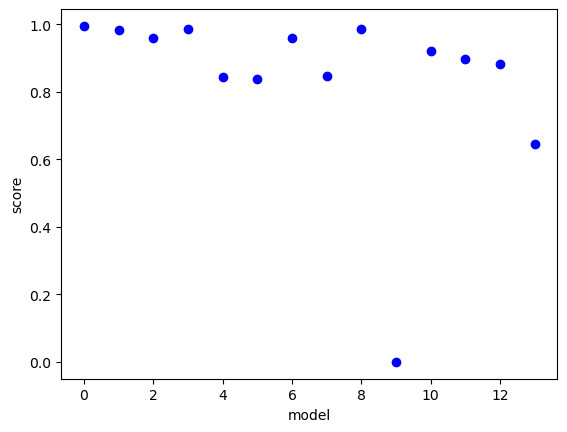

x0=5.909 x0^2 + 0.733 x0_t + -3.821 x0_1 + -0.476 x0_11 + 4.420 x0_111 + 39.603 x0x0_t + 63.589 x0x0_1 + 3.577 x0x0_11, score=0.9953057986757392
x0x0_1=0.001 x0 + -0.007 x0^2 + -0.004 x0_t + 0.149 x0_1 + -0.076 x0_111, score=0.9850831961703618
x0_1=0.003 x0 + -0.109 x0_t + 0.054 x0_11 + 0.219 x0_111 + 5.887 x0x0_1 + 1.113 x0x0_111, score=0.9849180811666086
x0^2=0.164 x0 + -0.569 x0_t + -0.333 x0_1 + 0.107 x0_11 + -0.066 x0_111 + -0.850 x0x0_1 + -2.673 x0x0_11, score=0.9818802436997969
x0_t=0.144 x0 + -0.840 x0^2 + -0.537 x0_1 + 0.428 x0_11 + -0.266 x0_111 + 2.456 x0x0_t + -3.161 x0x0_11, score=0.9588813649349541


In [23]:
lhs_actual=pde_lib.transform(u)
lhs_predict=model.predict(u)


scores=[r2_score(lhs_actual[:,ind],lhs_predict[:,ind]) for ind in range(lhs_predict.shape[-1])]

plt.plot(scores,'bo')
plt.xlabel('model')
plt.ylabel('score')
plt.show()

order=np.argsort(scores)
for ind in np.flip(order[-5:]):
    print(pde_lib.get_feature_names()[ind] + '=' + model.equations()[ind] + ', score=' +str(scores[ind]))